# Handwriting Recognition

## Cell below to be deleted after running once

In [9]:
pip install numpy pandas keras opencv-python imutils matplotlib seaborn scikit-learn


  Obtaining dependency information for opencv-python from https://files.pythonhosted.org/packages/38/d2/3e8c13ffc37ca5ebc6f382b242b44acb43eb489042e1728407ac3904e72f/opencv_python-4.8.1.78-cp37-abi3-win_amd64.whl.metadata
   ---------------------------------------- 0.0/38.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.1 MB 196.9 kB/s eta 0:03:14
   ---------------------------------------- 0.1/38.1 MB 302.7 kB/s eta 0:02:06
   ---------------------------------------- 0.1/38.1 MB 327.7 kB/s eta 0:01:56
   ---------------------------------------- 0.1/38.1 MB 379.3 kB/s eta 0:01:41
   ---------------------------------------- 0.2/38.1 MB 513.4 kB/s eta 0:01:14
   ------------------------------

## Importing necessary packages

In [108]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
import os
import random 
import cv2
import imutils
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras import optimizers
from sklearn.preprocessing import LabelBinarizer
from keras import backend as K
from keras.layers import Dense, Activation, Flatten, Dense,MaxPooling2D, Dropout
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

## Preprocessing the data

### Build the dataframe of image of 64x255 and corresponding label

In [177]:
def resize_image(img):
    (h, w) = img.shape
    final_img = np.ones([64, 256]) * 255  #blank white image

    # crop
    if w > 256:
        img = img[:, :256]
        
    if h > 64:
        img = img[:64, :]

    final_img[:h, :w] = img
    return final_img


def get_dataframe(directory, csv_filepath, filecount):
    
    #Loading the csv files containing the labels
    labels_df = pd.read_csv(csv_filepath)

    data = []
    
    count = 0 #counter for the size of the dataframe
    
    for img_filename in os.listdir(directory):
        if count >= filecount:
            break
        
        #Get image in grayscale
        img_path = os.path.join(directory, img_filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        #Resize the image
        img = resize_image(img)
        img = img / 255. #normalization
        
        #Find corresponding label for the image in the csv file
        label = labels_df.loc[labels_df["FILENAME"] == img_filename, "IDENTITY"].values
        
        #Check if the label is not 'UNREADABLE'
        if label[0] != 'UNREADABLE':
            #Add the image and its label to the data
            data.append([img, label[0]])
            count += 1
    
    #Build the dataframe
    df = pd.DataFrame(data, columns=["Image", "Label"])
    print(df.shape)
    print(df.head())
    
    return df

In [178]:
train_size = 10
train_data = get_dataframe('dataset/train', 'dataset/written_name_train_v2.csv', train_size)

test_size = 10
test_data = get_dataframe('dataset/test', 'dataset/written_name_test_v2.csv', test_size)

validation_size = 10
validation_data = get_dataframe('dataset/validation', 'dataset/written_name_validation_v2.csv', validation_size)



(10, 2)
                                               Image      Label
0  [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...  BALTHAZAR
1  [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...      SIMON
2  [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...      BENES
3  [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...    LA LOVE
4  [[0.9372549019607843, 0.3764705882352941, 0.0,...     DAPHNE
(10, 2)
                                               Image     Label
0  [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...     KEVIN
1  [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...  CLOTAIRE
2  [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...      LENA
3  [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...     JULES
4  [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...   CHERPIN
(10, 2)
                                               Image       Label
0  [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...       BILEL
1  [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...  LAUMIONIER
2  [[1.0, 1.0, 1.0,

In [189]:
def get_features_and_labels(data):
    X = data.iloc[:, 0].tolist()
    Y = data.iloc[:, 1].tolist()
    
    return X, Y

In [202]:
train_x, train_y = get_features_and_labels(train_data)
validation_x, validation_y = get_features_and_labels(validation_data)
test_x, test_y = get_features_and_labels(test_data)


train_x = np.array(train_x).reshape(-1, 256, 64, 1)
test_x = np.array(test_x).reshape(-1, 256, 64, 1)
validation_x = np.array(validation_x).reshape(-1, 256, 64, 1)

### Visualize the image

In [203]:
def visualize_image(image_data, index):
    
    image = image_data[index].reshape(64, 256)
    
    # Display the image
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

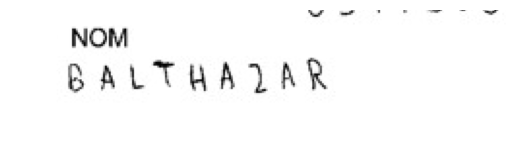

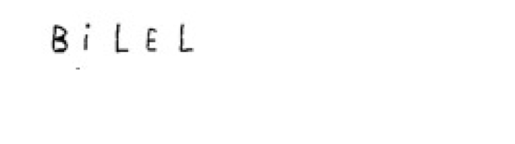

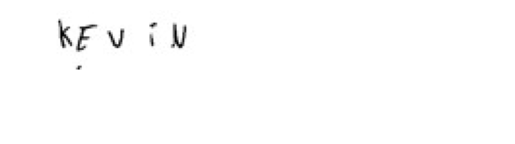

In [204]:
visualize_image(train_x, 0)
visualize_image(validation_x, 0)
visualize_image(test_x, 0)

In [ ]:
train_y = np.array(train_y)
test_y = np.array(test_y)
validation_y = np.array(validation_y)

lb = LabelBinarizer()
train_y = lb.transform(train_y)
test_y = lb.fit_trans